In [2]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled.parquet')
# datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled.parquet')


# data_sso = pd.read_parquet('//Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled_sso.parquet')
# datat_sso = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_sso.parquet')


impl_volatility = 'impl_volatility_h_1_step'
# # Filter data to ensure 'prc_option' is below a certain number, e.g., 0.5
# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]
# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]


test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]

totalList = basic
tickers_groups = ['AMZN', 'TSLA', ['META', 'MSFT','NVDA', 'AAPL']]

In [18]:
data_filter = data[data['prc_option'] < 0.125]
data_filter

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all


In [19]:
datat

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
173372,2021-01-04,0,127000,1.45,1.47,17546,8555,0.463496,-0.340291,0.058356,...,0,0,0,AAPL,0.493447,0.416914,25617.160,11873.451191,0.323912,0.492819
173373,2021-01-04,0,128000,1.81,1.83,16803,5309,0.457994,-0.400309,0.062264,...,0,0,0,AAPL,0.474071,0.414822,30581.460,14006.125191,0.323912,0.492819
173374,2021-01-04,0,129000,2.24,2.26,19938,6957,0.454101,-0.463866,0.064565,...,0,0,0,AAPL,0.457912,0.413991,44860.500,20371.197910,0.323912,0.492819
173375,2021-01-04,0,130000,2.73,2.76,28333,12142,0.450365,-0.528973,0.065199,...,0,0,0,AAPL,0.445151,0.413657,77774.085,35026.725791,0.323912,0.492819
173376,2021-01-04,0,131000,3.25,3.35,11935,4399,0.445678,-0.594095,0.064216,...,0,0,0,AAPL,0.433588,0.413453,39385.500,17553.250869,0.323912,0.492819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273794,2021-12-30,0,3455000,79.55,86.00,150,132,0.258606,-0.961871,0.001832,...,0,0,0,AMZN,0.232330,0.199780,12416.250,3210.916747,0.240320,0.474367
273795,2021-12-30,0,3460000,84.55,91.00,14,242,0.271209,-0.963420,0.001688,...,0,0,0,AMZN,0.233141,0.181504,1228.850,333.275180,0.240320,0.474367
273796,2021-12-30,0,3465000,89.40,96.00,67,137,0.278041,-0.967644,0.001491,...,0,0,0,AMZN,0.233369,0.163282,6210.900,1726.884847,0.240320,0.474367
273797,2021-12-30,0,3475000,99.30,105.85,41,129,0.291246,-0.974592,0.001167,...,0,0,0,AMZN,0.234573,0.126994,4205.575,1224.856896,0.240320,0.474367


All Data In-sample RMSE: 0.31230109153281654
All Data In-sample R²: 0.46675377295588727
All Data Out-of-sample RMSE: 0.24316408771757114
All Data Out-of-sample R²: 0.5328875240803013
Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.007653475632765516
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/adhbs.csv


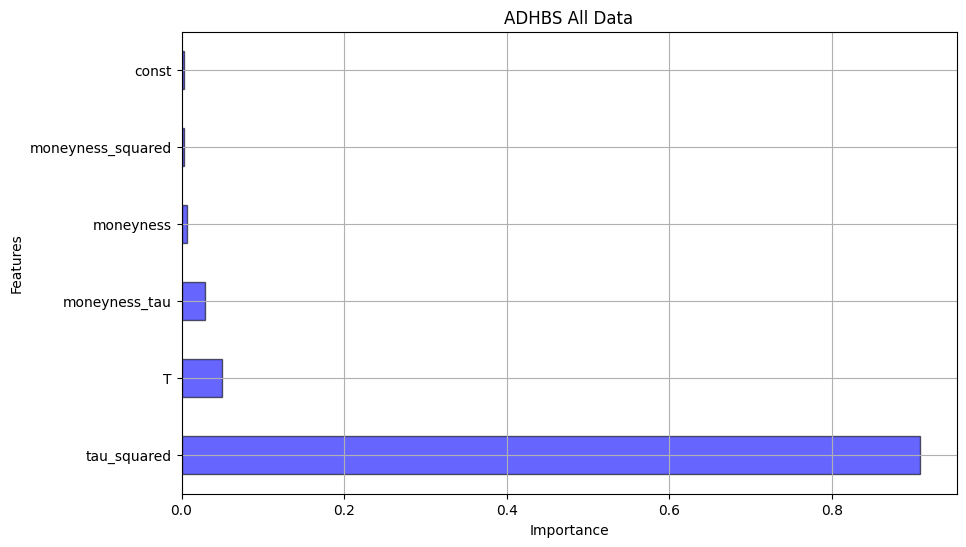

Newey-West Standard Error (All Data): 0.007653475632765516
Top 10 Features (Feature, Importance):
tau_squared          0.907867
T                    0.049976
moneyness_tau        0.028643
moneyness            0.006681
moneyness_squared    0.003559
const                0.003273
dtype: float64
AAPL RMSE: 0.22983932923037453
AAPL R²: -0.8011997635451509


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11926/2694834150.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ols_model.bse[0]  # Standard error of the constant term


AMZN RMSE: 0.21714433579784864
AMZN R²: 0.2565644277540704
NVDA RMSE: 0.21715049662246788
NVDA R²: 0.5255527915618131
TSLA RMSE: 0.31038004857934653
TSLA R²: 0.49274686803636003
META RMSE: 0.20415987630117985
META R²: -0.03021382728557276
MSFT RMSE: 0.26111690976446844
MSFT R²: -2.4824990623240093
Overall Weighted R²: 0.1666457820390974
Overall Weighted RMSE: 0.23992650927413606


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term


def run_ols(data, datat, title):
    """Runs OLS regression, calculates RMSE and R², and returns the top 10 most important features, normalized."""
    # Prepare the training data
    y_train = data[impl_volatility]
    X_train = data[totalList]
    X_train = sm.add_constant(X_train)  # Add a constant for intercept

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the in-sample (training) data
    y_train_pred = model.predict(X_train)

    # Calculate RMSE and R² for in-sample data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    print(f'{title} In-sample RMSE: {rmse_train}')

    r2_train = r2_score(y_train, y_train_pred)
    print(f'{title} In-sample R²: {r2_train}')

    # Prepare the test data (out-of-sample) and manually add the constant term with the same name as training
    y_test = datat[impl_volatility]
    X_test = datat[totalList]
    X_test.insert(0, 'const', 1)  # Add a constant column with value 1

    # Predict on the out-of-sample (test) data using the fitted model
    y_test_pred = model.predict(X_test)

    # Calculate RMSE and R² for out-of-sample data
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'{title} Out-of-sample RMSE: {rmse_test}')

    r2_test = r2_score(y_test, y_test_pred)
    print(f'{title} Out-of-sample R²: {r2_test}')

    # Calculate prediction errors
    errors_test = y_test - y_test_pred
    datat['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in datat.columns:
        daily_avg_errors = datat.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/adhbs.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")



    # Create the feature importance plot (sum of importances = 1)
    coefs = model.params  # Get coefficients
    importance = coefs.abs() / coefs.abs().sum()  # Normalize importance so it sums to 1

    # Get top 10 most important features
    top_10_features = importance.sort_values(ascending=False).head(10)

    # Plot the feature importance with a black border and wider bars
    plt.figure(figsize=(10, 6))
    ax = top_10_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black', linewidth=1)
    plt.grid(True)  # Add grid
    ax.set_title(f'ADHBS {title}')  # Simplified title to OLS Call or OLS Put
    ax.set_xlabel('Importance')  # Set x-label for importance
    ax.set_ylabel('Features')  # Ensure Y label is present

    plt.show()

    return model, top_10_features, daily_avg_errors

# Run OLS for the entire dataset
model, top_10_features, errors_all = run_ols(data, datat, "All Data")

# Calculate Newey-West standard error for the entire dataset
nw_std_error_all = newey_west_standard_error(errors_all, lag=1)
print(f"Newey-West Standard Error (All Data): {nw_std_error_all}")

# Print the top 10 features with importance values
print("Top 10 Features (Feature, Importance):")
print(top_10_features)

# Use the obtained coefficients for each ticker to calculate implied volatility
results_list_all = []  # Initialize list to store results

unique_tickers = datat['Ticker'].unique()

for ticker in unique_tickers:
    # Filter the data for the current ticker
    data_ticker = datat[datat['Ticker'] == ticker]

    # Prepare the data for prediction and manually add the constant term
    X_ticker = data_ticker[totalList]
    X_ticker.insert(0, 'const', 1)  # Add a constant column with value 1

    # Predict implied volatility using the coefficients from the entire model
    y_ticker_pred = model.predict(X_ticker)

    # Calculate RMSE and R² for the ticker-specific implied volatility prediction
    y_ticker_actual = data_ticker[impl_volatility]
    rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
    r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

    # # Calculate Newey-West standard error for ticker-specific errors
    # errors_ticker = y_ticker_actual - y_ticker_pred
    # nw_std_error_ticker = newey_west_standard_error(errors_ticker, lag=1)


    # Save results in the list
    results_list_all.append({
        'Ticker': ticker,
        'RMSE': rmse_ticker,
        'R²': r2_ticker
    })

    print(f'{ticker} RMSE: {rmse_ticker}')
    print(f'{ticker} R²: {r2_ticker}')

# Calculate weighted metrics
results_df = pd.DataFrame(results_list_all)

# Add the number of observations for each ticker
results_df['Observations'] = results_df['Ticker'].map(datat['Ticker'].value_counts())

# Compute weights as the proportion of observations for each ticker
results_df['Weight'] = results_df['Observations'] / results_df['Observations'].sum()

# Calculate weighted metrics
results_df['Weighted_R²'] = results_df['R²'] * results_df['Weight']
results_df['Weighted_RMSE'] = results_df['RMSE'] * results_df['Weight']

# Calculate the overall weighted R² and RMSE
overall_weighted_r2 = results_df['Weighted_R²'].sum()
overall_weighted_rmse = results_df['Weighted_RMSE'].sum()

# Output results
print("Overall Weighted R²:", overall_weighted_r2)
print("Overall Weighted RMSE:", overall_weighted_rmse)

Baseline R² (OOS): 0.5329
Feature: moneyness, Baseline R²: 0.5329, Perturbed R²: -1614.8956, Drop: 1615.4285
Feature: T, Baseline R²: 0.5329, Perturbed R²: -13.5786, Drop: 14.1115
Feature: moneyness_squared, Baseline R²: 0.5329, Perturbed R²: -506.3623, Drop: 506.8952
Feature: tau_squared, Baseline R²: 0.5329, Perturbed R²: -1.1867, Drop: 1.7196
Feature: moneyness_tau, Baseline R²: 0.5329, Perturbed R²: -5.6108, Drop: 6.1437


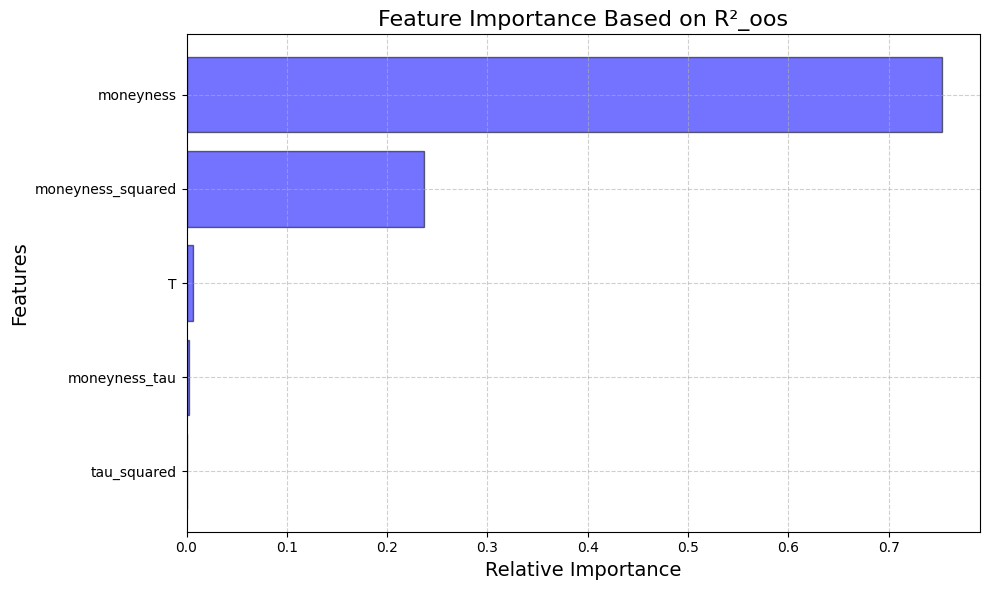

In [21]:
def calculate_feature_importance_r2(data_train, data_test, features, target):
    """
    Calculate feature importance based on the relative drop in R²_oos when a feature is set to zero,
    ensuring importance scores are non-negative.

    Parameters:
    - data_train: Training dataset
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (implied volatility)
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    """
    # Train the model on the training data
    y_train = data_train[target]
    X_train = data_train[features]
    X_train = sm.add_constant(X_train)  # Add constant for intercept

    model = sm.OLS(y_train, X_train).fit()

    # Predict on the test data and calculate baseline R²
    y_test = data_test[target]
    X_test = data_test[features]
    X_test = sm.add_constant(X_test)

    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate drop in R² for each feature
    r2_drops = []
    for feature in features:
        # Create a copy of test data with the feature set to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0

        # Predict with the perturbed test data
        y_test_pred_zeroed = model.predict(X_test_zeroed)

        # Calculate R² with the feature set to zero
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_drop = max(0, baseline_r2 - r2_zeroed)  # Ensure the drop is non-negative
        r2_drops.append(r2_drop)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Drop: {r2_drop:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_drops)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all drops are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2



def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example Usage
# Calculate feature importance based on R²_oos
feature_importance_df, baseline_r2 = calculate_feature_importance_r2(data_train=data, data_test=datat, features=totalList, target=impl_volatility)

# Plot feature importance
plot_feature_importance(feature_importance_df, title="Feature Importance Based on R²_oos")


In [22]:
feature_importance_df["Importance"].tolist()

[0.7533598648782209,
 0.2363920877528066,
 0.006580953488234193,
 0.002865145667635765,
 0.0008019482131024207]

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def run_ols(train_data, test_data, title):
    """Runs OLS regression on 'train_data', evaluates out-of-sample on 'test_data', calculates RMSE and R²."""

    # Prepare the training data
    y_train = train_data[impl_volatility]
    X_train = train_data[totalList]
    X_train = sm.add_constant(X_train)

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the in-sample (training) data
    y_train_pred = model.predict(X_train)

    # Calculate RMSE and R² for in-sample data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f'{title} In-sample RMSE: {rmse_train}')
    print(f'{title} In-sample R²: {r2_train}')

    # Prepare the test data (out-of-sample)
    y_test = test_data[impl_volatility]
    X_test = test_data[totalList]
    X_test = sm.add_constant(X_test)

    # Predict on the out-of-sample (test) data using the fitted model
    y_test_pred = model.predict(X_test)

    # Calculate RMSE and R² for out-of-sample data
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    print(f'{title} Out-of-sample RMSE: {rmse_test}')
    print(f'{title} Out-of-sample R²: {r2_test}')

    return model, rmse_train, r2_train, rmse_test, r2_test

# Initialize variables to store weighted sums
weighted_rmse_train_sum = 0
weighted_r2_train_sum = 0
weighted_rmse_test_sum = 0
weighted_r2_test_sum = 0
total_train_rows = 0
total_test_rows = 0

## Initialize list to store individual ticker results
results_list_sso = []

# Run OLS for each unique ticker and store the results
results = {}
unique_tickers = data['Ticker'].unique()

for ticker in unique_tickers:
    # Filter the data for the current ticker
    train_data = data[data
    ['Ticker'] == ticker]
    test_data = datat[datat['Ticker'] == ticker]

    # Run OLS for the current ticker
    model_ticker, rmse_train, r2_train, rmse_test, r2_test = run_ols(train_data, test_data, ticker)
    results[ticker] = {
        'model': model_ticker
    }

    # Calculate the number of rows in the training and test sets for the current ticker
    num_train_rows = len(train_data)
    num_test_rows = len(test_data)

    # Update weighted sums for in-sample RMSE and R²
    weighted_rmse_train_sum += rmse_train * num_train_rows
    weighted_r2_train_sum += r2_train * num_train_rows
    total_train_rows += num_train_rows

    # Update weighted sums for out-of-sample RMSE and R²
    weighted_rmse_test_sum += rmse_test * num_test_rows
    weighted_r2_test_sum += r2_test * num_test_rows
    total_test_rows += num_test_rows

    # Save individual ticker results in the list
    results_list_sso.append({
        'Ticker': ticker,
        'RMSE': rmse_test,
        'R²': r2_test
    })

# Calculate weighted averages for in-sample RMSE and R²
weighted_avg_rmse_train = weighted_rmse_train_sum / total_train_rows
weighted_avg_r2_train = weighted_r2_train_sum / total_train_rows

# Calculate weighted averages for out-of-sample RMSE and R²
weighted_avg_rmse_test = weighted_rmse_test_sum / total_test_rows
weighted_avg_r2_test = weighted_r2_test_sum / total_test_rows

print(f'Weighted Average In-sample RMSE: {weighted_avg_rmse_train}')
print(f'Weighted Average In-sample R²: {weighted_avg_r2_train}')
print(f'Weighted Average Out-of-sample RMSE: {weighted_avg_rmse_test}')
print(f'Weighted Average Out-of-sample R²: {weighted_avg_r2_test}')


AMZN In-sample RMSE: 0.22560937445051807
AMZN In-sample R²: 0.4593641692953869
AMZN Out-of-sample RMSE: 0.17560742877986224
AMZN Out-of-sample R²: 0.506177788107969
META In-sample RMSE: 0.24992514729346843
META In-sample R²: 0.3732939946636622
META Out-of-sample RMSE: 0.17977715310615924
META Out-of-sample R²: 0.18281718278568038
MSFT In-sample RMSE: 0.23373496136480526
MSFT In-sample R²: 0.3964311988280852
MSFT Out-of-sample RMSE: 0.15141992374704052
MSFT Out-of-sample R²: -0.1987810083994861
TSLA In-sample RMSE: 0.38444768394485457
TSLA In-sample R²: 0.48950462687373464
TSLA Out-of-sample RMSE: 0.2995565223609123
TSLA Out-of-sample R²: 0.5216434168481499
AAPL In-sample RMSE: 0.19143503349729368
AAPL In-sample R²: 0.4061682846307082
AAPL Out-of-sample RMSE: 0.17114809017852434
AAPL Out-of-sample R²: -0.006380538086021792
NVDA In-sample RMSE: 0.26606518615932956
NVDA In-sample R²: 0.4193562256074971
NVDA Out-of-sample RMSE: 0.2197960522841579
NVDA Out-of-sample R²: 0.5054605532637404
W

In [15]:
results_list_sso

[{'Ticker': 'AMZN', 'RMSE': 0.17560742877986224, 'R²': 0.506177788107969},
 {'Ticker': 'META', 'RMSE': 0.17977715310615924, 'R²': 0.18281718278568038},
 {'Ticker': 'MSFT', 'RMSE': 0.15141992374704052, 'R²': -0.1987810083994861},
 {'Ticker': 'TSLA', 'RMSE': 0.2995565223609123, 'R²': 0.5216434168481499},
 {'Ticker': 'AAPL', 'RMSE': 0.17114809017852434, 'R²': -0.006380538086021792},
 {'Ticker': 'NVDA', 'RMSE': 0.2197960522841579, 'R²': 0.5054605532637404}]

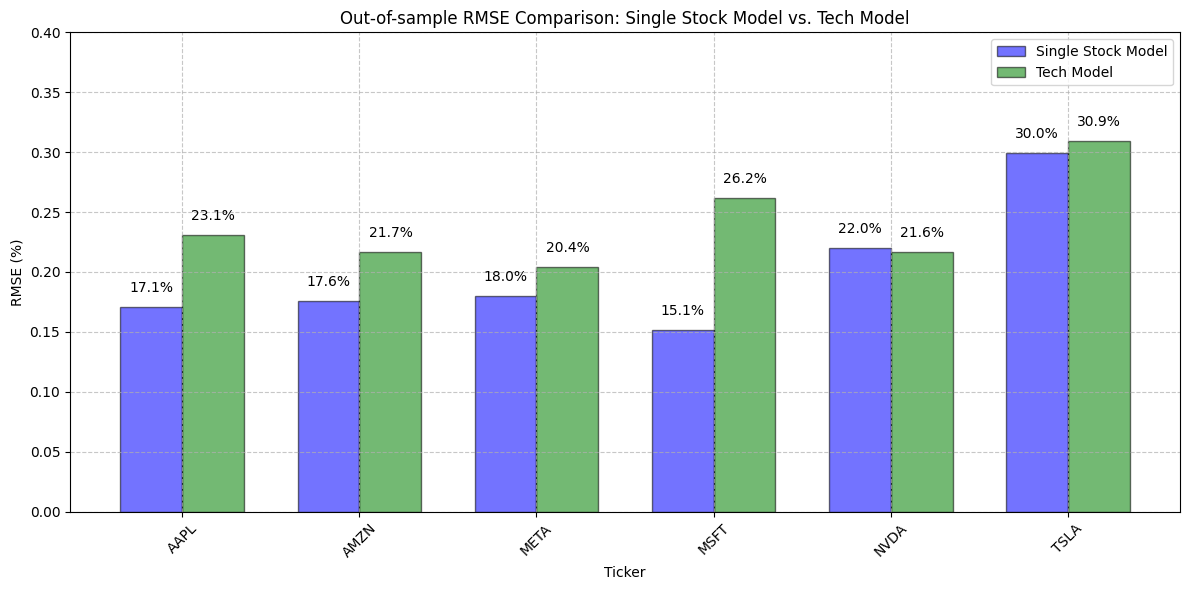

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11926/2311213965.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


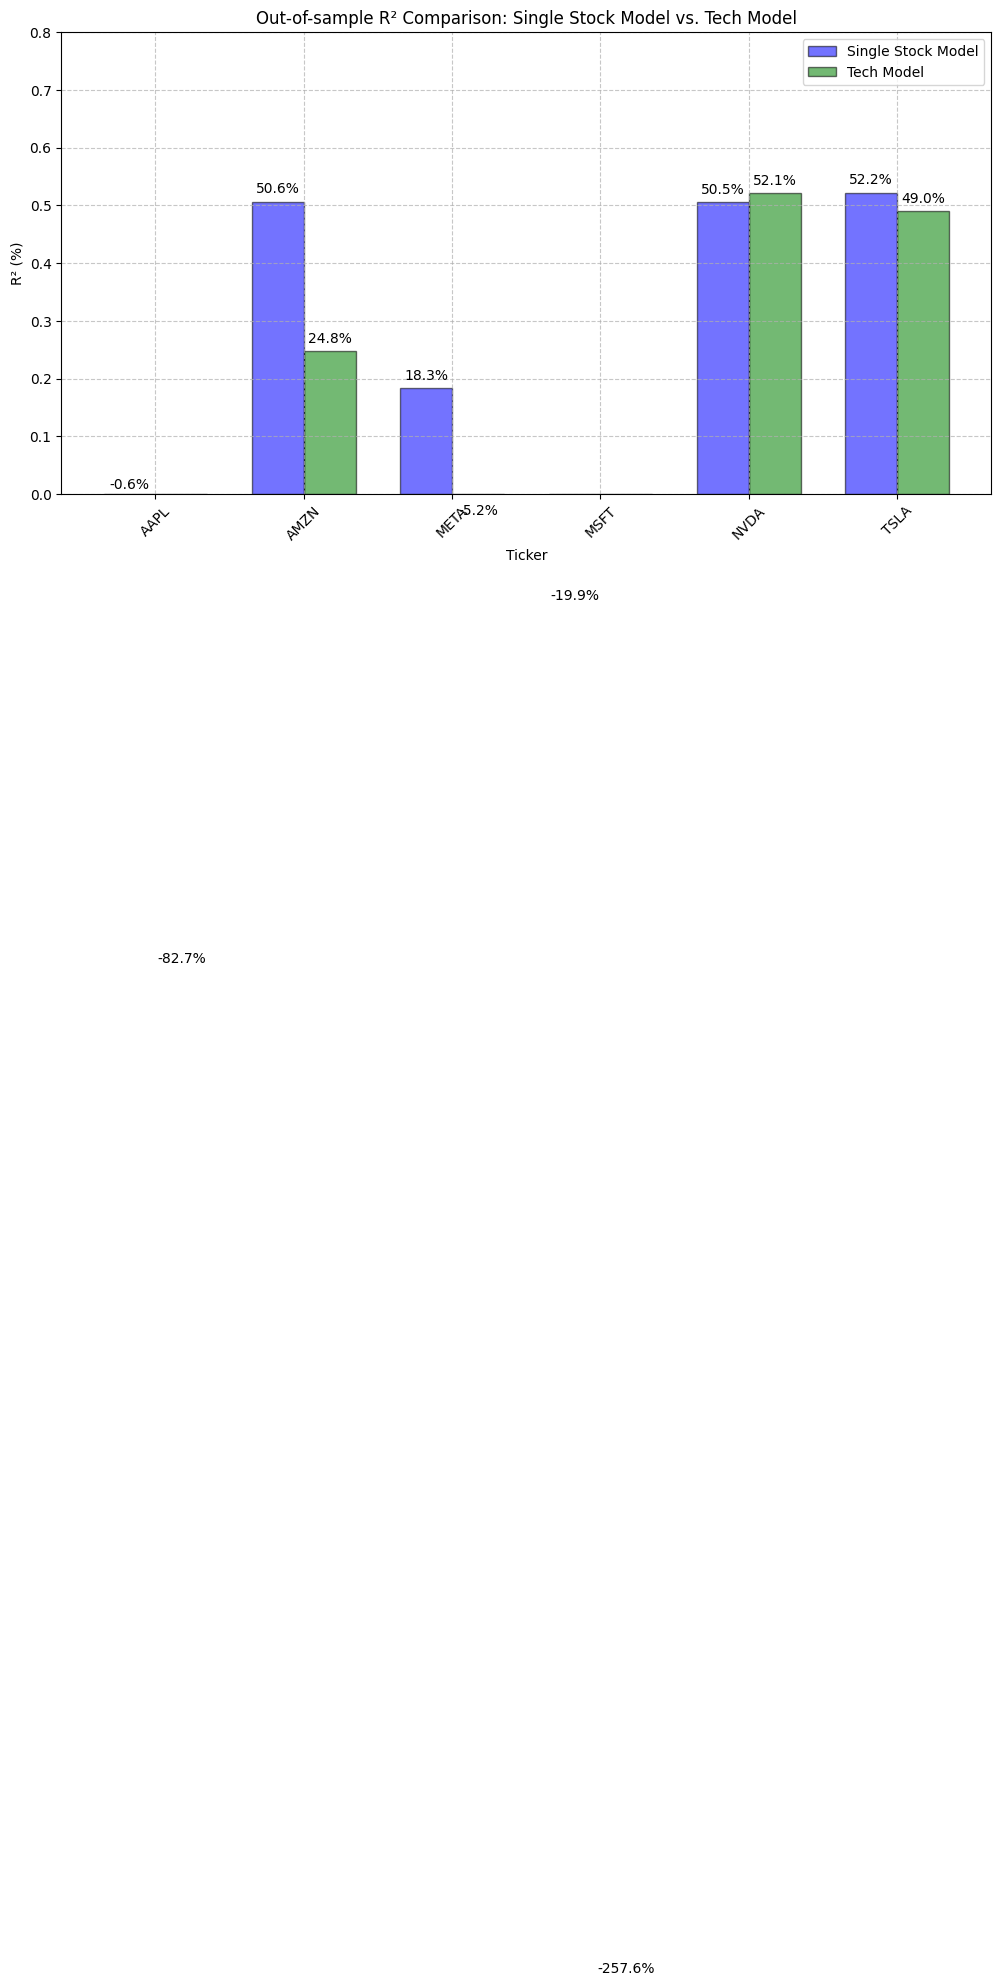

In [16]:
# Convert lists to DataFrames for easier plotting
results_list_sso_df = pd.DataFrame(results_list_sso).set_index('Ticker').sort_index()
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_sso_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_sso_rmse = plt.bar(x - width/2, results_list_sso_df['RMSE'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_rmse = plt.bar(x + width/2, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_sso_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.4])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_sso_r2 = plt.bar(x - width/2, results_list_sso_df['R²'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_r2 = plt.bar(x + width/2, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_sso_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.8])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
